Implementation of the paper:  

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95

**Neuron model**  

The network we study is composed of 4,000 leaky integrate-and-fire neurons. To create self-sustained, asynchronous background activity, we chose a 4:1 ratio of excitatory to inhibitory neurons in the network and connected them to each other randomly with a connection probability of 2%.  

In COBA network, each integrate-and-fire neuron is characterized by a time constant, $\tau$ = 20 ms, and a resting membrane potential, $V_{rest}$ = -60 mV. Whenever the membrane potential crosses a spiking threshold of -50 mV, an action potential is generated and the membrane potential is reset to the resting potential, where it remains clamped for a 5 ms refractory period. The membrane voltages are calculated as follows:  

$$  
\tau \frac{dV}{dt} = (V_{rest} - V) + I  
$$  

The $I$ is the synaptic input, which consists of two parts:  

$$I = g_{exc}(E_{exc} - V) + g_{inh}(E_{inh} - V) + I_{ext}$$  

where reversal potentials are $E_{exc} = 0$ mV and $E_{inh} = -80$ mV, $I_{ext}=20$.

![EI_balance.png](img/E_I_balance_network.png)

**Synapse model**  

In COBA network, when a neuron fires, the appropriate synaptic variable of its postsynaptic targets are increased, $g_{exc} \gets g_{exc} + \Delta g_{exc}$ for an excitatory presynaptic neuron and $g_{inh} \gets g_{inh} + \Delta g_{inh}$ for an inhibitory presynaptic neuron. Otherwise, these parameters obey the following equations:  

$$\tau_{exc} {dg_{exc} \over dt} = -g_{exc}$$  
$$\tau_{inh} {dg_{inh} \over dt} = -g_{inh}$$  

with synaptic time constants $\tau_{exc} = 5$ ms, $\tau_{inh} = 10$ ms, $\Delta g_{exc} = 0.6$ and $\Delta g_{inh} = 6.7$.

An E-I balanced network is composed of two neuron groups and the synaptic connections between them. Specifically, they include:
1. a group of excitatory neurons, $\mathrm{E}$,
2. a group of inhibitory neurons, $\mathrm{I}$,
3. synaptic connections within the excitatory and inhibitory neuron groups, respectively, and 
4. the inter-connections between these two groups.

To construct the network, we need to define these components one by one. BrainPy provides plenty of handy built-in models for brain dynamic simulation. They are contained in ``brainpy.dyn``. Let's choose the simplest yet the most canonical neuron model, the Leaky Integrate-and-Fire (LIF) model, to build the excitatory and inhibitory neuron groups.

In [1]:
import brainpy as bp
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt

/home/spirit/anaconda3/envs/winsch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we use the Align post projection method (``bp.dyn.ProjAlignPost2``) to simulate synaptic connections. Among the parameters of the model, the first two denotes the pre- and post-synaptic neuron groups, respectively. The third one refers to the connection types. In this example, we use ``bp.conn.FixedProb``, which connects the pre-synaptic neurons to postsynaptic neurons with a given probability (detailed information is available in [Synaptic Connection](../tutorial_toolbox/synaptic_connections.ipynb)). The following three parameters describes the dynamic properties of the synapse, and the last one is the numerical integration method as that in the LIF model.

In [2]:
# 基于 align post Exponential synaptic computation
class Exponential(bp.Projection): 
  def __init__(self, pre, post, delay, prob, g_max, tau, E, label=None):
    super().__init__()
    self.pron = bp.dyn.ProjAlignPost2(
      pre=pre,
      delay=delay,
      comm=bp.dnn.EventCSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max), # 随机连接
      syn=bp.dyn.Expon(size=post.num, tau=tau),# Exponential synapse
      out=bp.dyn.COBA(E=E), # COBA network
      post=post,
      out_label=label
    )

Here we use the Align post projection method (``bp.dyn.ProjAlignPost2``) to simulate synaptic connections. Among the parameters of the model, the first two denotes the pre- and post-synaptic neuron groups, respectively. The third one refers to the connection types. In this example, we use ``bp.conn.FixedProb``, which connects the pre-synaptic neurons to postsynaptic neurons with a given probability (detailed information is available in [Synaptic Connection](../tutorial_toolbox/synaptic_connections.ipynb)). The following three parameters describes the dynamic properties of the synapse, and the last one is the numerical integration method as that in the LIF model.

In [3]:
# 构建 E-I Balanced Network

class EINet(bp.DynamicalSystem):
  def __init__(self, ne=3200, ni=800):
    super().__init__()
    
    # bp.neurons.LIF()
    self.E = bp.dyn.LifRef(ne, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                           V_initializer=bp.init.Normal(-55., 2.))
    #### TO DO!!!对照兴奋性神经元群体组写抑制性神经元群体
    self.I = bp.dyn.LifRef(ni, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                           V_initializer=bp.init.Normal(-55., 2.))

    #### E2E，E2I，I2E，I2I Exponential synaptic computation
    # delay=0,prob=0.02, g_max_E=0.6, g_max_I=6.7, tau_E=5, tua_I=10,
    # reversal potentials E_E=0, E_E=-80, label=EE,EI,IE,II
    self.E2E = Exponential(self.E, self.E, 0., 0.02, 0.6, 5., 0., 'EE')
    self.E2I = Exponential(self.E, self.I, 0., 0.02, 0.6, 5., 0., 'EI')
    self.I2E = Exponential(self.I, self.E, 0., 0.02, 6.7, 10., -80., 'IE')
    self.I2I = Exponential(self.I, self.I, 0., 0.02, 6.7, 10., -80., 'II')

  def update(self, inp=0.):
    #### TO DO!!!更新突触传入电流
    self.E2E()
    self.E2I()
    self.I2E()
    self.I2I()

    ### TO DO!!!更新神经元群体
    self.E(inp)
    self.I(inp)

    # 记录需要 monitor的变量
    E_E_inp = self.E.sum_inputs(self.E.V, label='EE')  # E2E的输入
    I_E_inp = self.E.sum_inputs(self.E.V, label='IE')  # I2E的输入
    return self.E.spike, self.I.spike, E_E_inp, I_E_inp

Predict 1000 steps: : 100%|██████████| 1000/1000 [00:01<00:00, 691.56it/s]


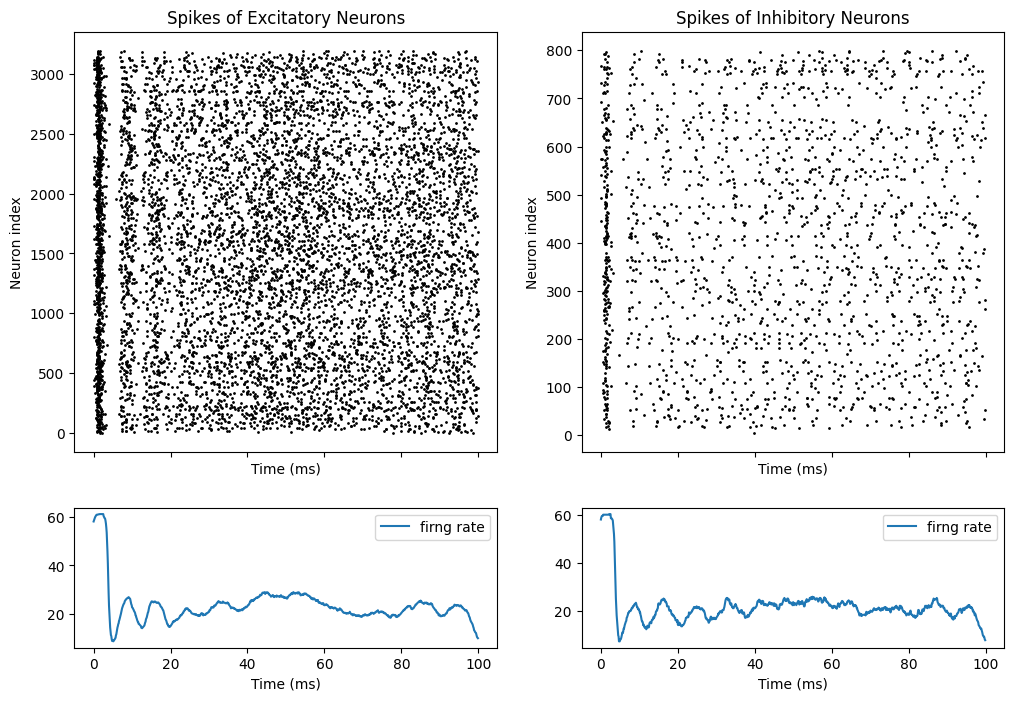

In [4]:
# 数值模拟
model = EINet(ne=3200, ni=800) #实现4000个神经元的E-I模型，其中E：I=4:1
runner = bp.DSRunner(model)
inputs = np.ones(1000) * 20.  # 100 ms
e_sps, i_sps, ee_inps, ie_inps = runner.run(inputs=inputs)

# 可视化
# 兴奋性脉冲发放
fig, gs = plt.subplots(2,2,gridspec_kw={'height_ratios': [3, 1]}, figsize=(12, 8), sharex='all')
plt.sca(gs[0,0])
bp.visualize.raster_plot(runner.mon['ts'], e_sps, title= 'Spikes of Excitatory Neurons')
plt.sca(gs[0,1])
bp.visualize.raster_plot(runner.mon['ts'], i_sps, title= 'Spikes of Inhibitory Neurons')

# 平均发放速率
plt.sca(gs[1,0])
rate_e = bp.measure.firing_rate(e_sps, 5.)
bp.visualize.line_plot(runner.mon['ts'], rate_e, legend='firng rate')
plt.sca(gs[1,1])
rate_i = bp.measure.firing_rate(i_sps, 5.)
bp.visualize.line_plot(runner.mon['ts'], rate_i, legend='firng rate',show=True)

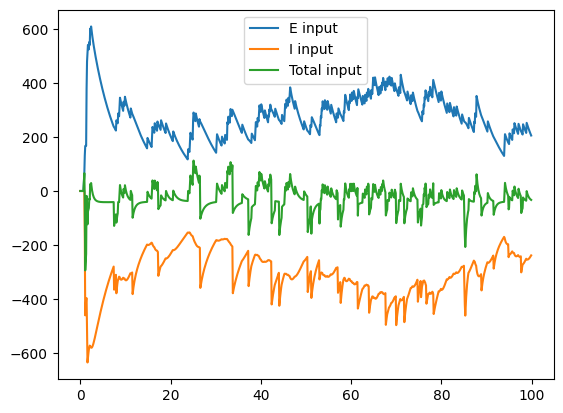

In [5]:
# 画单个神经元收到的兴奋性输入和抑制性输入强度
ind=170
plt.plot(runner.mon['ts'], ee_inps[:,ind],runner.mon['ts'], ie_inps[:,ind],runner.mon['ts'], ee_inps[:,ind]+ie_inps[:,ind])
plt.legend(['E input','I input','Total input'])

**Properties of a E-I Balanced Network**  

External input strength is “linearly” encoded by the mean firing rate of the neural population  

The network responds rapidly to abrupt changes of the input

Predict 60000 steps: : 100%|██████████| 60000/60000 [00:08<00:00, 6736.35it/s]


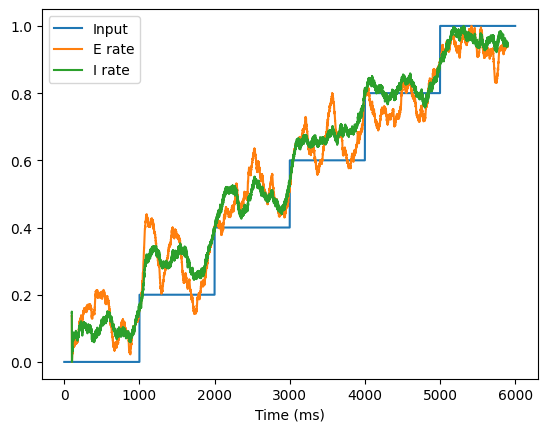

In [6]:
# 构建分段电流
inputs = np.ones(60000)   # 6000 ms
dur_per_I = 10000# duration = 1000 ms
Is = np.array([20., 40., 60., 80.,100.,120.])
ind_dur=0
for I in Is:
    inputs[ind_dur:ind_dur+dur_per_I]=inputs[ind_dur:ind_dur+dur_per_I]*I
    ind_dur=ind_dur+dur_per_I

# 运行数值模拟
model = EINet(ne=3200, ni=800)
runner = bp.DSRunner(model)
e_sps, i_sps, ee_inps, ie_inps = runner.run(inputs=inputs)

def normal(data):
    _rang=np.max(data)-np.min(data)
    return (data-np.min(data))/_rang

bp.visualize.line_plot(runner.mon['ts'], normal(inputs), legend='Input')
rate_e = bp.measure.firing_rate(e_sps, 200.)
bp.visualize.line_plot(runner.mon['ts'][1000:-1000], normal(rate_e[1000:-1000]), legend='E rate')
rate_i = bp.measure.firing_rate(i_sps, 200.)
bp.visualize.line_plot(runner.mon['ts'][1000:-1000], normal(rate_i[1000:-1000]), legend='I rate',show=True)

Predict 60000 steps: : 100%|██████████| 60000/60000 [00:08<00:00, 6800.08it/s]


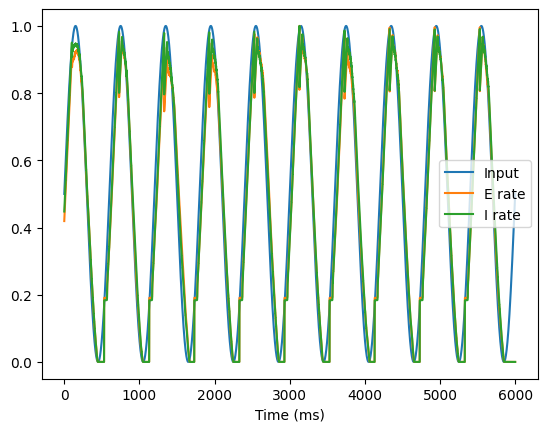

In [7]:
# 构建sin()形式的电流输入
x = np.linspace(0, 20*np.pi, 60000)
inputs = np.sin(x)*100   # 6000 ms


# 运行数值模拟
model = EINet(ne=3200, ni=800)
runner = bp.DSRunner(model)
e_sps, i_sps, ee_inps, ie_inps = runner.run(inputs=inputs)


bp.visualize.line_plot(runner.mon['ts'], normal(inputs), legend='Input')
rate_e = bp.measure.firing_rate(e_sps, 200.)
bp.visualize.line_plot(runner.mon['ts'], normal(rate_e), legend='E rate')
rate_i = bp.measure.firing_rate(i_sps, 200.)
bp.visualize.line_plot(runner.mon['ts'], normal(rate_i), legend='I rate',show=True)